# Import Statements

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pytz
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl
import math

# Parameters

In [2]:
source = 'combined'
sensor = 'pm25'
res_time = '3H'
filepath_root = '/scratch/ab9738/epod-nyu-delhi-pollution/'
spikes_file = filepath_root+'ankit/spikes.csv'
time_high_file = filepath_root+'ankit/time_high_3H.pkl'
time_low_file = filepath_root+'ankit/time_low_3H.pkl'
space_high_file = filepath_root+'ankit/space_high_3H.pkl'
space_low_file = filepath_root+'ankit/space_low_3H.pkl'

# Data Loading

In [3]:
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/epod-nyu-delhi-pollution/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

# Load Hotspots

In [4]:
with open(time_low_file,'rb') as file:
    thsp_low = pkl.load(file)

In [5]:
with open(time_high_file,'rb') as file:
    thsp_high = pkl.load(file)

In [6]:
with open(space_high_file,'rb') as file:
    shsp_high = pkl.load(file)
with open(space_low_file,'rb') as file:
    shsp_low = pkl.load(file)

# Plot Spatial Hotspots

In [7]:
shsp_high = np.array(shsp_high)
shsp_low = np.array(shsp_low)

/state/partition1/job-19505561/ipykernel_236045/1418123353.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shsp_high = np.array(shsp_high)
/state/partition1/job-19505561/ipykernel_236045/1418123353.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shsp_low = np.array(shsp_low)


In [8]:
hsp = deepcopy(shsp_high[1000])
hsp

array([Timestamp('2019-01-01 21:00:00+0530', tz='pytz.FixedOffset(330)'),
       '56C3', list(['RKPuram_DPCC', 'JNS_DPCC'])], dtype=object)

In [9]:
hsps_high = shsp_high[shsp_high[:,0]==hsp[0]]
# hsps_low = shsp_low[shsp_low[:,0]==hsp[0]]
# hsps = np.concatenate((hsps_high,hsps_low))
hsps = hsps_high
ts = hsps[0][0]
print(hsps)

for i in range(len(hsps)):
    hsp = hsps[i]
    hsp_nns = []
    for pl in hsp[2]:
        if(abs(df.loc[hsp[0]][hsp[1]]-df.loc[hsp[0]][pl])<50):
            hsp_nns.append(pl)
    hsps[i][2] = hsp_nns
hsps_n = []
for i in range(len(hsps)):
    hsps_n.append([hsps[i][1]]+hsps[i][2])
hsps = hsps_n
hsps

[[Timestamp('2019-01-01 21:00:00+0530', tz='pytz.FixedOffset(330)')
  '56C3' list(['RKPuram_DPCC', 'JNS_DPCC'])]
 [Timestamp('2019-01-01 21:00:00+0530', tz='pytz.FixedOffset(330)')
  'AnandVihar_DPCC' list(['VivekVihar_DPCC', 'SoniaVihar_DPCC'])]
 [Timestamp('2019-01-01 21:00:00+0530', tz='pytz.FixedOffset(330)')
  'BurariCrossing_IMD'
  list(['AshokVihar_DPCC', 'Wazirpur_DPCC', 'Rohini_DPCC'])]
 [Timestamp('2019-01-01 21:00:00+0530', tz='pytz.FixedOffset(330)')
  'Jahangirpuri_DPCC' list([])]
 [Timestamp('2019-01-01 21:00:00+0530', tz='pytz.FixedOffset(330)')
  'Mundaka_DPCC' list([])]
 [Timestamp('2019-01-01 21:00:00+0530', tz='pytz.FixedOffset(330)')
  'NehruNagar_DPCC' list([])]
 [Timestamp('2019-01-01 21:00:00+0530', tz='pytz.FixedOffset(330)')
  'Patparganj_DPCC' list(['BC46', '113E'])]]


[['56C3', 'RKPuram_DPCC'],
 ['AnandVihar_DPCC', 'VivekVihar_DPCC', 'SoniaVihar_DPCC'],
 ['BurariCrossing_IMD', 'AshokVihar_DPCC', 'Rohini_DPCC'],
 ['Jahangirpuri_DPCC'],
 ['Mundaka_DPCC'],
 ['NehruNagar_DPCC'],
 ['Patparganj_DPCC', 'BC46']]

In [10]:
hsps

[['56C3', 'RKPuram_DPCC'],
 ['AnandVihar_DPCC', 'VivekVihar_DPCC', 'SoniaVihar_DPCC'],
 ['BurariCrossing_IMD', 'AshokVihar_DPCC', 'Rohini_DPCC'],
 ['Jahangirpuri_DPCC'],
 ['Mundaka_DPCC'],
 ['NehruNagar_DPCC'],
 ['Patparganj_DPCC', 'BC46']]

In [11]:
val_df = deepcopy(df.loc[ts])

In [12]:
val_df = val_df.fillna(val_df.mean())

In [13]:
locs_map = locs.loc[val_df.index]

In [14]:
locs_map = locs_map.drop(labels='Pusa_DPCC')
locs_map = locs_map.rename(index={'Pusa_IMD':'Pusa_IMD_DPCC'})
# locs_map

In [15]:
val_df = (val_df-val_df.min())/(val_df.max()-val_df.min())

In [16]:
val_df.loc['Pusa_IMD_DPCC'] = (val_df.loc['Pusa_IMD']+val_df.loc['Pusa_DPCC'])/2
val_df.drop(labels=['Pusa_IMD', 'Pusa_DPCC'])
val_df

field_egg_id
113E                     0.611951
1FD7                     0.560867
20CA                     0.254627
2E9C                     0.560867
3ACF                     0.560867
                           ...   
SoniaVihar_DPCC          0.833164
SriAurobindoMarg_DPCC    0.370447
VivekVihar_DPCC          0.857411
Wazirpur_DPCC            0.803016
Pusa_IMD_DPCC            0.321328
Name: 2019-01-01 21:00:00+05:30, Length: 61, dtype: float64

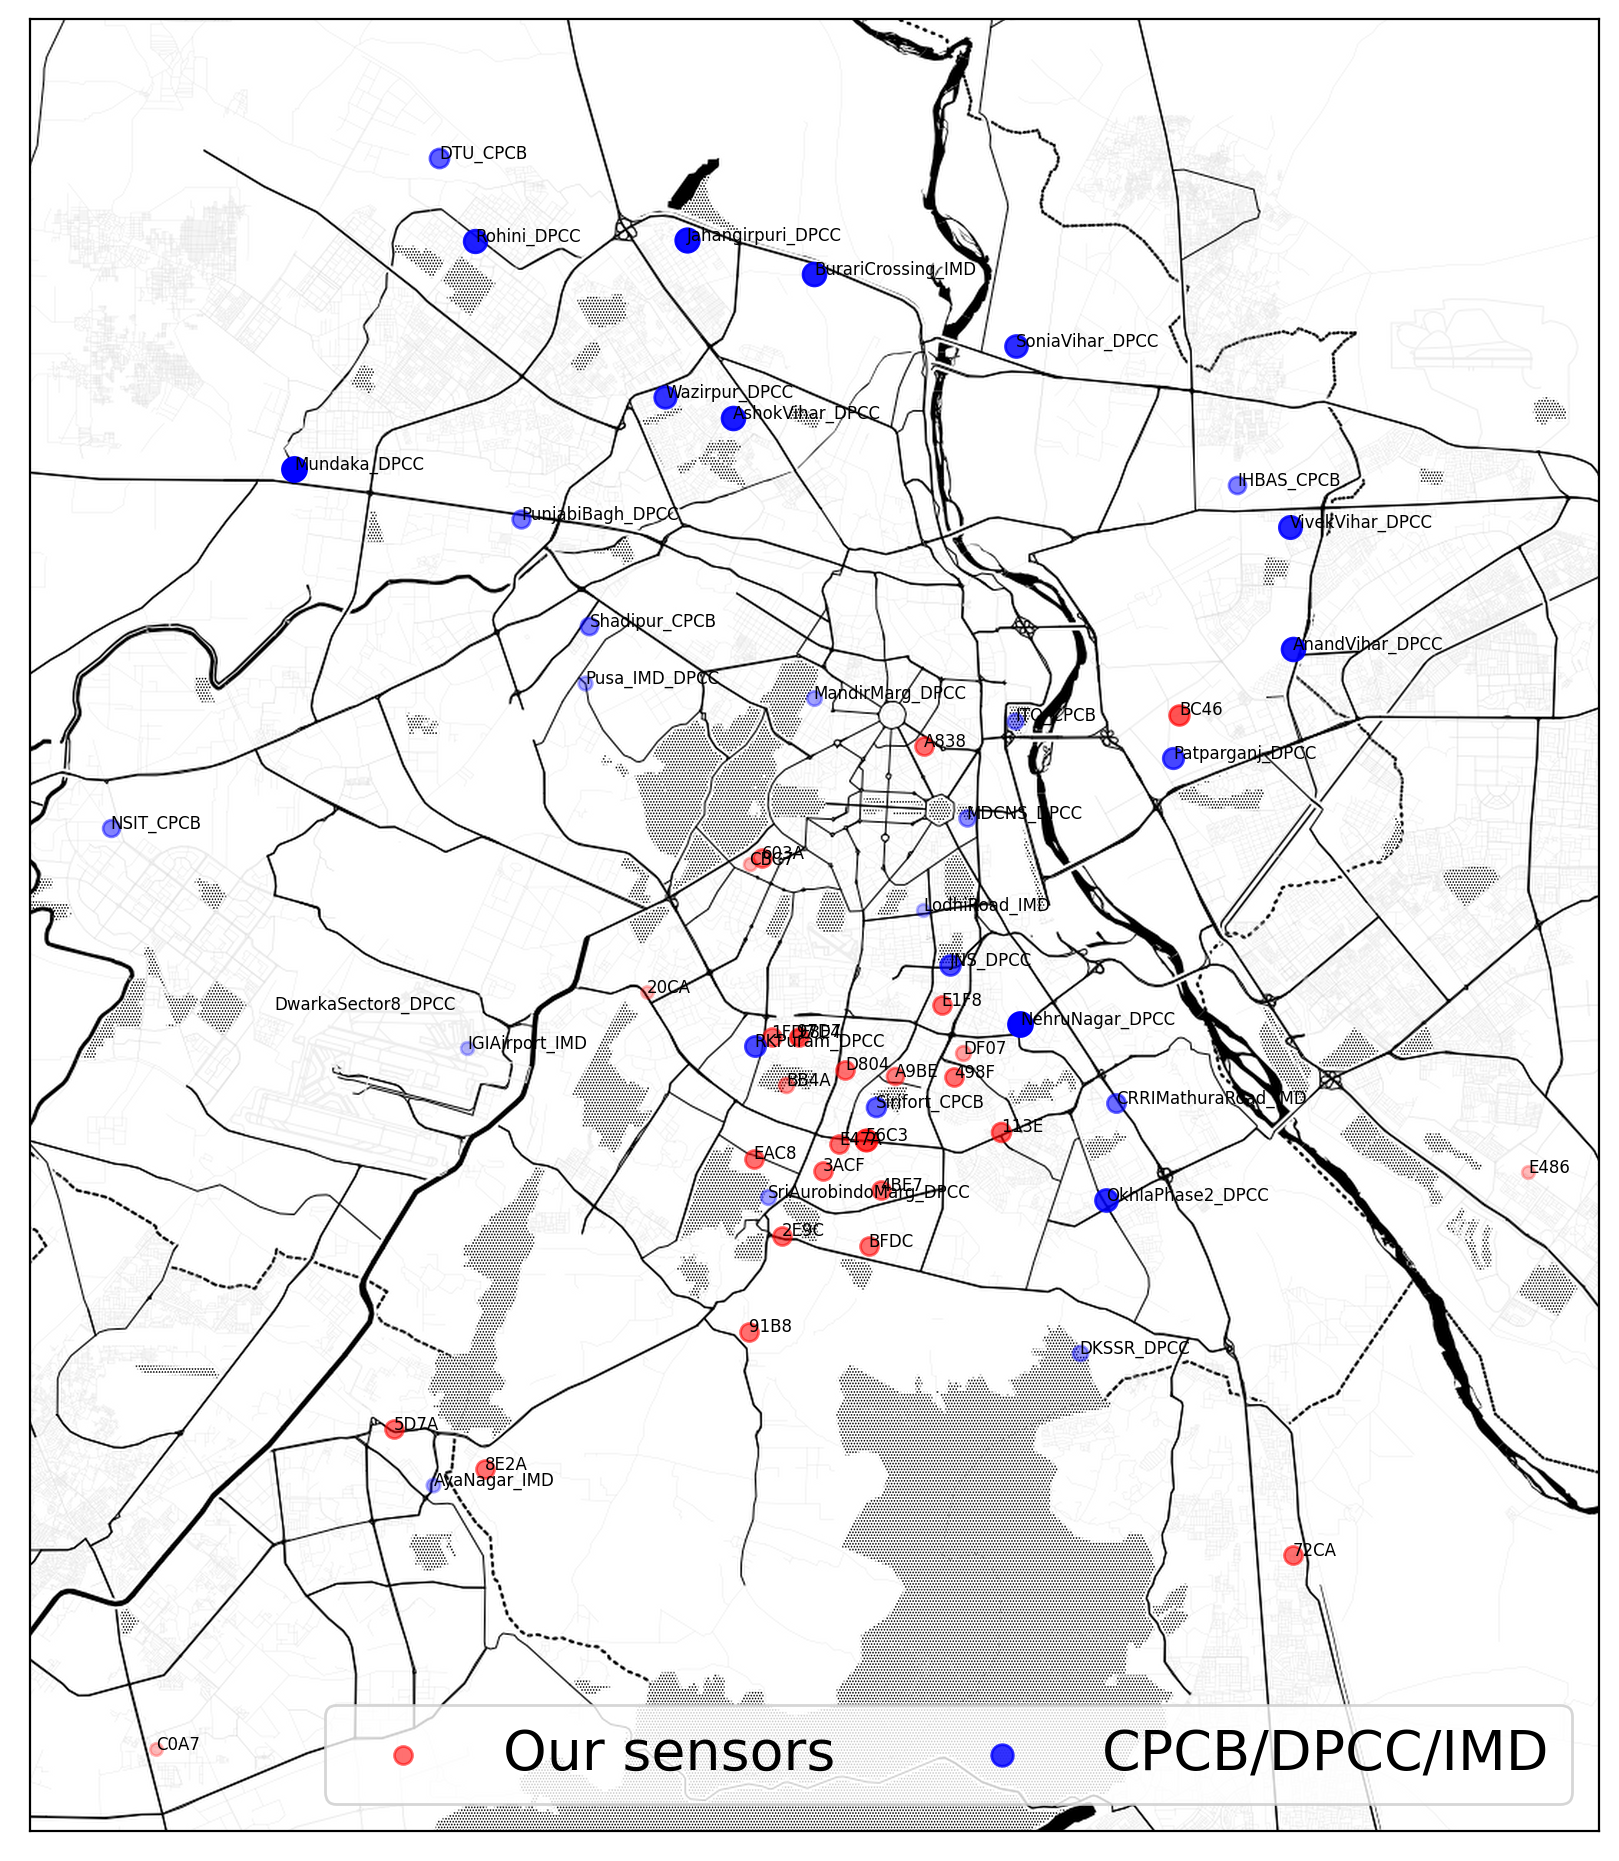

In [17]:
lat_lims = locs.Latitude.min(), locs.Latitude.max()
lon_lims = locs.Longitude.min(), locs.Longitude.max()
lon_center, lat_center = locs.Longitude.mean(), locs.Latitude.mean()


lat_pad = 1.1 * max(lat_center - lat_lims[0], lat_lims[1] - lat_center)
lon_pad = 1.1 * max(lon_center - lon_lims[0], lon_lims[1] - lon_center)
    
extent = tilemapbase.Extent.from_lonlat(lon_center - lon_pad, 
                                        lon_center + lon_pad, 
                                        lat_center - lat_pad, 
                                        lat_center + lat_pad)

extent_proj = extent.to_project_3857

t = tilemapbase.tiles.Stamen_Toner_Background

colordict = {'Kaiterra':'r', 'Govt':'b'}

plt.rc('font', size=20)

fig, ax = plt.subplots(figsize=(12,12), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

for row in locs_map.itertuples():
    x, y = tilemapbase.project(row.Longitude, row.Latitude)
    if row.Type == 'Kaiterra':
        obj1 = ax.scatter(x, y, marker='.', color='r',\
                          s=300*val_df.loc[row.Index], label='Our sensors', alpha=val_df.loc[row.Index])
    else:
        obj2 = ax.scatter(x, y, marker='.', color='b',\
                          s=300*val_df.loc[row.Index], label='CPCB/DPCC/IMD', alpha=val_df.loc[row.Index])
    ax.text(x, y, row.Index, fontsize=6)

ax.legend((obj1, obj2), (obj1.get_label(), obj2.get_label()), loc='lower right', ncol=2)

# cords = []
# for hsp in hsps:
#     cord_elt = []
#     for l in hsp:
#         x,y = tilemapbase.project(locs_map.loc[l].Longitude,\
#                                   locs_map.loc[l].Latitude)
#         cord_elt.append([x,y])
#     cords.append(cord_elt)

# el = []
# for i in range(len(hsps)):
#     cord = np.array(cords[i])
#     x_mean = cord[:,0].mean()
#     y_mean = cord[:,1].mean()
#     if(len(hsps[i])==1):
#         el.append(matplotlib.patches.Circle((x_mean,y_mean), 0.000035))
#     if(len(hsps[i])>=2):
#         x_max = max(cord[:,0])
#         x_min = min(cord[:,0])
#         y_max = max(cord[:,1])
#         y_min = min(cord[:,1])
#         x_diff = x_max-x_min
#         y_diff = y_max-y_min
#         slope = y_diff/x_diff
#         slope = 90-math.degrees(math.atan(slope))
#         diam = 2*math.sqrt(pow((x_mean-cord[0][0]),2) + pow((y_mean-cord[0][1]),2))
#         el.append(matplotlib.patches.Ellipse((x_mean,y_mean),\
#                                              0.000035,diam,slope))
#     else:
#         el.append(matplotlib.patches.Polygon(cord))
        

# for e in el:
#     ax.add_patch(e)
#     e.set_clip_box(ax.bbox)
#     e.set_facecolor('b')
#     e.set_alpha(0.1)
# ax.autoscale_view()
# plt.show()
plt.savefig('spatial_hotspots.png')

In [18]:
extent

Extent((0.7139254499578852,0.41646758178818666)->(0.7149705052930109,0.4176740618579234) projected as normal)

# Plot temporal hotspot

In [19]:
sta = 'Wazirpur_DPCC'

In [20]:
hsp = deepcopy(thsp_high[sta][6])
hsp

[Timestamp('2018-09-15 06:00:00+0530', tz='pytz.FixedOffset(330)'),
 311.5,
 array([Timestamp('2018-09-14 12:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-09-14 15:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-09-14 18:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-09-14 21:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-09-15 00:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-09-15 03:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-09-15 06:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-09-15 09:00:00+0530', tz='pytz.FixedOffset(330)'),
        Timestamp('2018-09-15 12:00:00+0530', tz='pytz.FixedOffset(330)')],
       dtype=object)]

In [21]:
ts_le = hsp[2][0]
ts_rb = hsp[2][-1]
wind = len(hsp[2])

In [22]:
ts = hsp[0]

In [23]:
ts

Timestamp('2018-09-15 06:00:00+0530', tz='pytz.FixedOffset(330)')

In [24]:
idx = list(df[sta].index)
idx_le = idx.index(ts_le)
idx_rb = idx.index(ts_rb)
idx_re = idx_rb+5*wind
idx_lb = idx_le-5*wind

In [25]:
idx_lb = max(0,idx_lb)
idx_re = min(idx_re,len(df))

In [26]:
idxs = np.array(idx)[idx_lb:idx_re+1]

In [27]:
np.where(idxs==ts)[0][0]

51

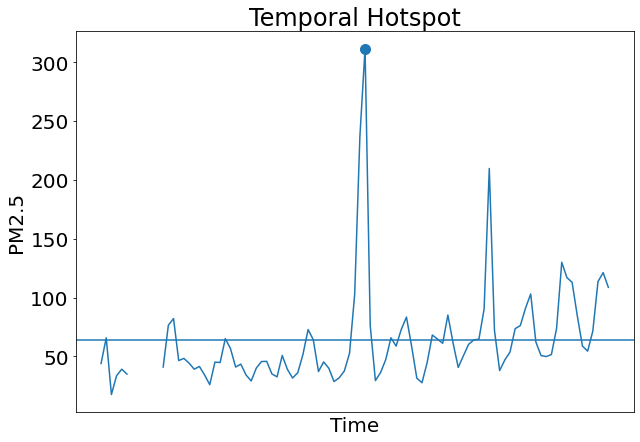

In [28]:
y = df[sta].loc[idxs].values
x = range(len(y))
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(x,y)
plt.axhline(y=np.nanmean(y))
plt.scatter(x[np.where(idxs==ts)[0][0]],y[np.where(idxs==ts)[0][0]],s=100)
# ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.title("Temporal Hotspot")
plt.savefig("temporal_hotspot.png")

# Chart Hotspot Profiles

In [29]:
df_counts = pd.read_csv('hotspot_counts_3H.csv',index_col=0)

In [30]:
df_counts.sort_values(by=['spatial_high'], ascending=False)[:10]

,spatial_high,spatial_low,temporal_high,temporal_low
NehruNagar_DPCC,247,1,136,80
Wazirpur_DPCC,246,6,130,82
Jahangirpuri_DPCC,212,5,124,84
Mundaka_DPCC,208,11,135,70
Rohini_DPCC,201,6,149,101
AnandVihar_DPCC,183,3,130,70
PunjabiBagh_DPCC,146,14,136,55
AshokVihar_DPCC,127,41,99,72
VivekVihar_DPCC,124,65,117,54
Shadipur_CPCB,107,55,87,16


In [50]:
df_chart = df_counts.sort_values(by=['spatial_high'], ascending=False)[:10]

<Figure size 432x288 with 0 Axes>

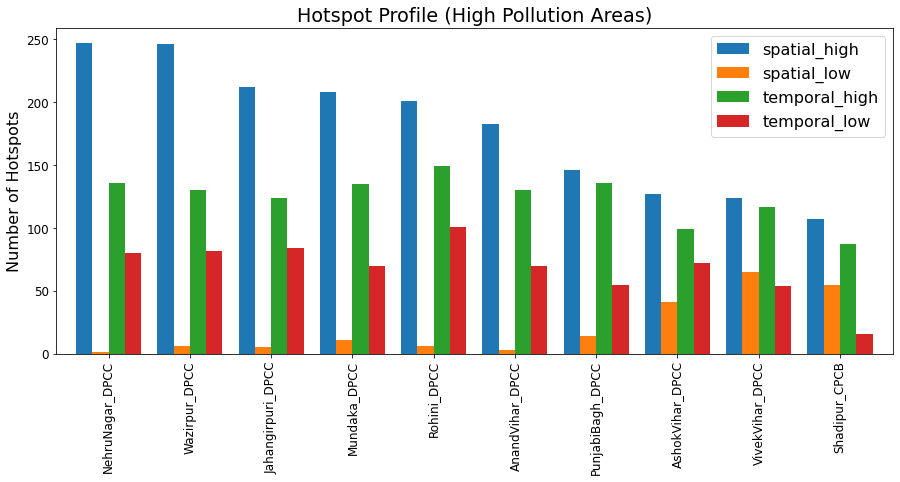

In [51]:
plt.figure()
plt.rcParams.update({'font.size': 16})
ax = df_chart.plot.bar(figsize=(15,6),fontsize=12,ylabel='Number of Hotspots',\
                       title='Hotspot Profile (High Pollution Areas)', width=0.8)
# plt.savefig('hp_hp.png')

In [48]:
df_chart = df_counts.sort_values(by=['spatial_low'], ascending=False)[:10]

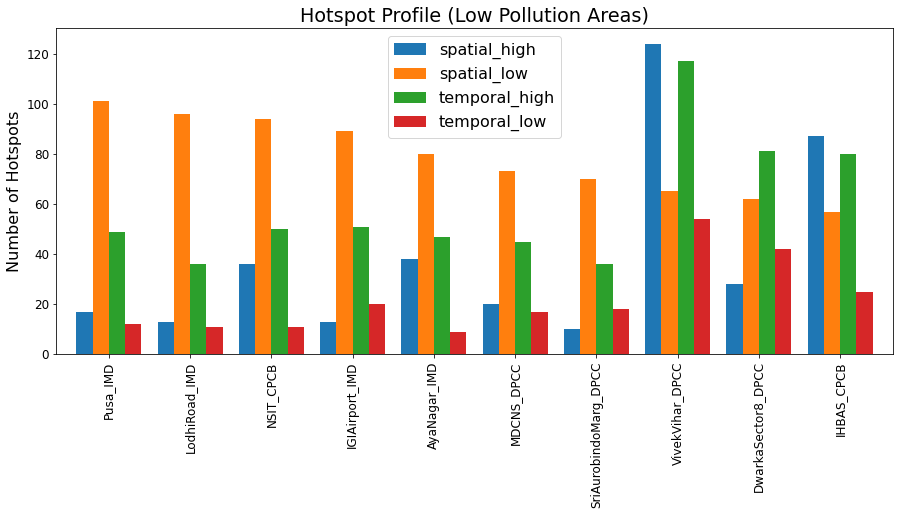

In [49]:
ax = df_chart.plot.bar(figsize=(15,6),fontsize=12,ylabel='Number of Hotspots',\
                       title='Hotspot Profile (Low Pollution Areas)',width=0.8)

# Plot Logitudnal Data

<AxesSubplot:title={'center':'Mundaka_DPCC'}, xlabel='Time', ylabel='PM2.5'>

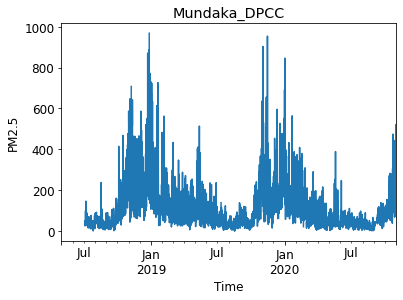

In [35]:
df['Mundaka_DPCC'].plot(ylabel='PM2.5',xlabel='Time',title='Mundaka_DPCC')

# Plot Diwali

In [36]:
diwali_ts = pd.Timestamp('2018-11-08 00:00:00+0530')

In [37]:
diwali_ts

Timestamp('2018-11-08 00:00:00+0530', tz='pytz.FixedOffset(330)')

/state/partition1/job-19505561/ipykernel_236045/2830662304.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(5,3.5))


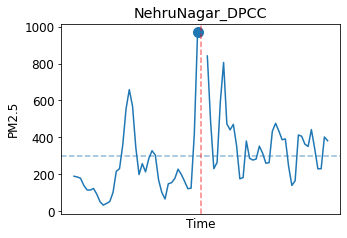

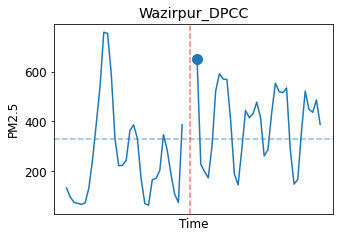

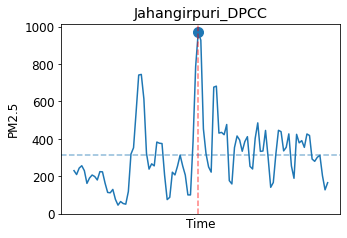

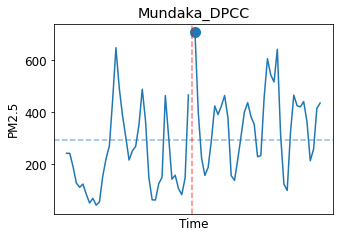

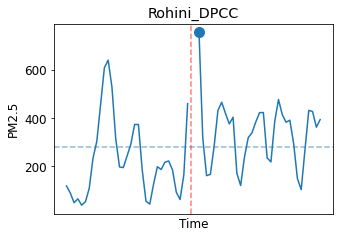

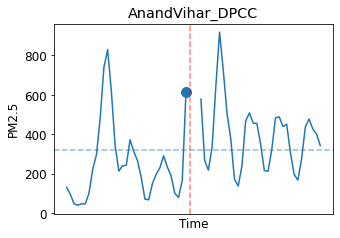

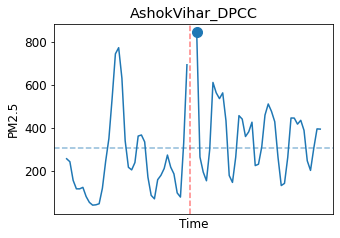

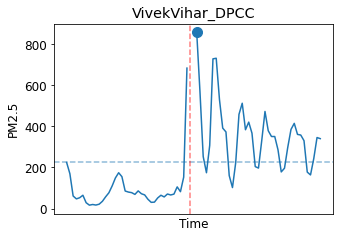

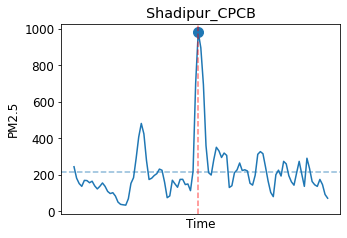

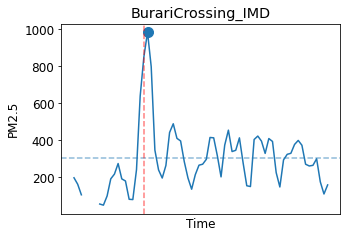

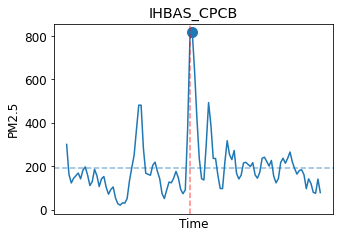

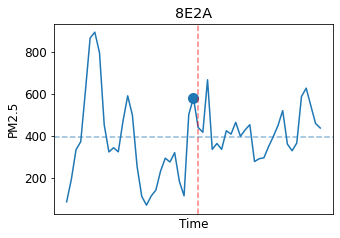

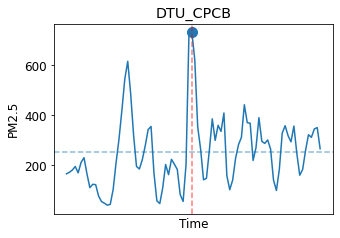

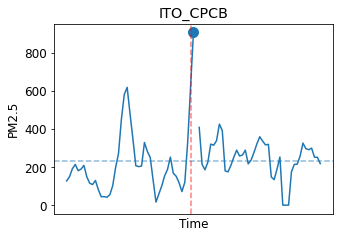

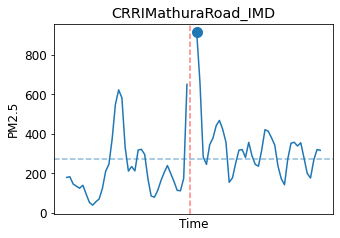

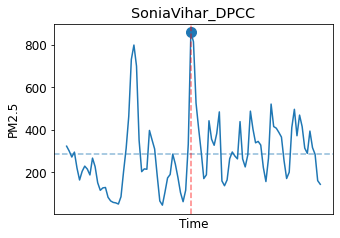

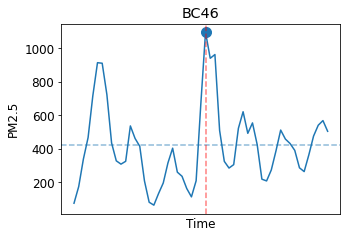

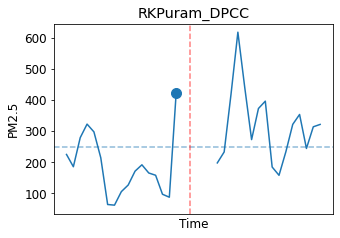

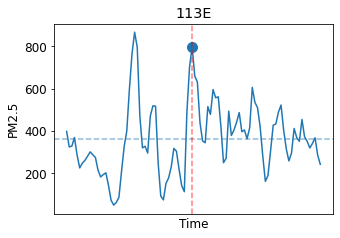

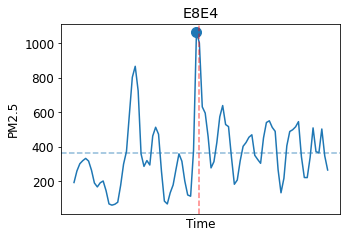

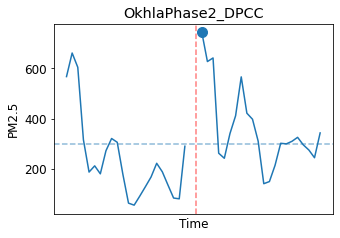

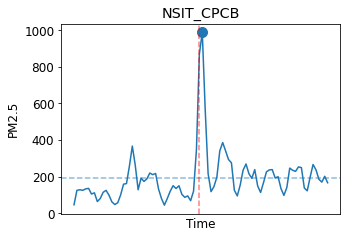

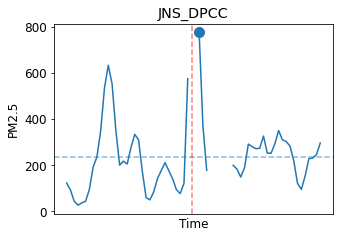

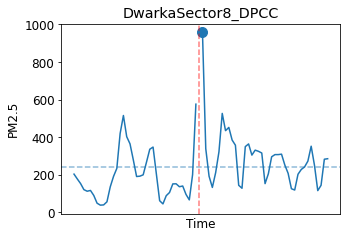

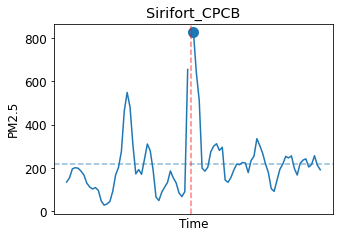

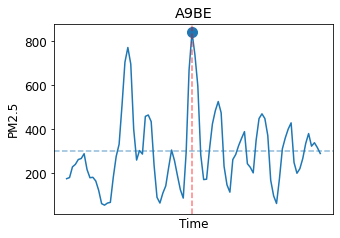

In [38]:
for station in df_counts.sort_values(by=['spatial_high'], ascending=False)[:30].index:
    for i in range(len(thsp_high[station])):
        hsp = thsp_high[station][i]
        if(hsp[2][0]<diwali_ts and hsp[2][-1]>diwali_ts):
            ts_le = hsp[2][0]
            ts_rb = hsp[2][-1]
            wind = len(hsp[2])
            ts = hsp[0]
            idx = list(df[station].index)
            idx_le = idx.index(ts_le)
            idx_rb = idx.index(ts_rb)
            idx_re = idx_rb+5*wind
            idx_lb = idx_le-5*wind
            idx_lb = max(0,idx_lb)
            idx_re = min(idx_re,len(df))
            idxs = np.array(idx)[idx_lb:idx_re+1]
            y = df[station].loc[idxs].values
            x = range(len(y))
            fig, ax = plt.subplots(figsize=(5,3.5))
            plt.plot(x,y)
            plt.axhline(y=np.nanmean(y), linestyle='--', alpha=0.5)
            hsp_idx = np.where(idxs==ts)[0][0]
            diwali_idx = np.where(idxs==diwali_ts)[0][0]
            plt.scatter(x[hsp_idx],y[hsp_idx],s=100)
#             plt.scatter(x[diwali_idx],y[diwali_idx],s=400,alpha=0.1,color='r')
            plt.axvline(x=diwali_idx, linestyle='--', alpha=0.5,color='r')
            # ax = plt.gca()
            ax.axes.xaxis.set_ticks([])
            plt.xlabel('Time')
            plt.ylabel('PM2.5')
            plt.title(station)
    #         plt.savefig("temporal_hotspot.png")

# Plot Heatmap of Delhi